In [1]:
import sys; sys.path.insert(0, '../..')

import fenics as fa
import matplotlib.pyplot as plt
import mshr
import numpy as np
import pdb
import argparse
import jax
from collections import namedtuple

from src.linear_stokes.linear_stokes_common import (
    plot_solution,
    loss_fn,
    fenics_to_jax,
    SecondOrderTaylorLookup,
    error_on_coords,
    sample_params,
    sample_points,
    loss_divu_fn,
    loss_stress_fn,
    get_p,
    get_u,
    deviatoric_stress
)

from src.linear_stokes.linear_stokes_fenics import (
    solve_fenics,
    is_defined,
    parser
)

In [2]:
args = parser.parse_args("")
args.bc_scale = 10.
args = namedtuple("ArgsTuple", vars(args))(**vars(args))

params = sample_params(jax.random.PRNGKey(args.seed), args)
source_params, bc_params, per_hole_params, num_holes = params
print("params: ", params)

params:  (DeviceArray([0.4130522 , 0.25975317], dtype=float32), DeviceArray([3.000803], dtype=float32), DeviceArray([[ 0.04156993, -0.0613506 ,  0.47837767,  0.20494777,
               0.44709057],
             [-0.03926784, -0.11530625,  0.10562178,  0.4114218 ,
               0.35706055],
             [-0.04186818,  0.01709074,  0.18381561, -0.53561956,
               0.29799348]], dtype=float32), DeviceArray(1, dtype=int32))


In [3]:
u_p_default = solve_fenics(params, boundary_points=32, resolution=128, impose_pressure=False)

In [4]:
u_p_left = solve_fenics(params, boundary_points=32, resolution=128, 
                        impose_pressure=True, pressure_val=0.0, wall='left_wall')

imposing left_wall pressure: 0.0 


In [5]:
u_p_right = solve_fenics(params, boundary_points=32, resolution=128, 
                         impose_pressure=True, pressure_val=0.0, wall='right_wall')

imposing right_wall pressure: 0.0 


In [6]:
points = sample_points(jax.random.PRNGKey(args.seed + 1), 1024, params)
points_on_inlet, points_on_walls, points_on_holes, points_in_domain = points

all_points = np.concatenate(points)

In [7]:
u_default, p_default = u_p_default.split()
u_left, p_left = u_p_left.split()
u_right, p_right = u_p_right.split()

In [45]:
left_pressure = []
left_x_velocity = []
left_y_velocity = []
left_wall = []
right_pressure = []
right_x_velocity = []
right_y_velocity = []
right_wall = []

for pt in points_on_inlet:
    if pt[0] < 0:
        left_pressure.append([p_default(pt), p_left(pt), p_right(pt)])
        left_x_velocity.append([u_default(pt)[0], u_left(pt)[0], u_right(pt)[0]])
        left_y_velocity.append([u_default(pt)[1], u_left(pt)[1], u_right(pt)[1]])
        left_wall.append(pt[1])
    else:
        right_pressure.append([p_default(pt), p_left(pt), p_right(pt)])
        right_x_velocity.append([u_default(pt)[0], u_left(pt)[0], u_right(pt)[0]])
        right_y_velocity.append([u_default(pt)[1], u_left(pt)[1], u_right(pt)[1]])
        right_wall.append(pt[1])

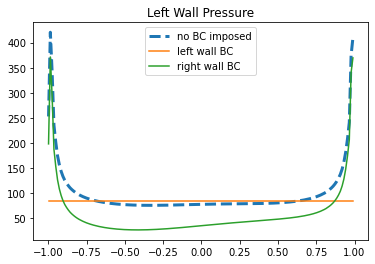

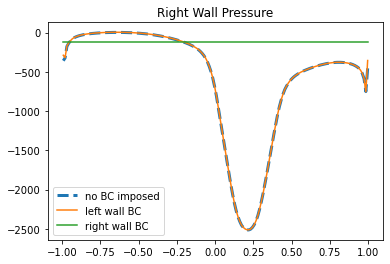

In [61]:
left_pressure = np.array(left_pressure)
plt.figure()
plt.plot(left_wall, left_pressure[:, 0],label='no BC imposed', lw=3, ls='--')
plt.plot(left_wall, left_pressure[:, 1],label='left wall BC')
plt.plot(left_wall, left_pressure[:, 2],label='right wall BC')
plt.title('Left Wall Pressure')
plt.legend()
#plt.ylim([0, 250])
plt.show()

right_pressure = np.array(right_pressure)
plt.figure()
plt.plot(right_wall,right_pressure[:, 0],label='no BC imposed', lw=3, ls='--')
plt.plot(right_wall,right_pressure[:, 1],label='left wall BC')
plt.plot(right_wall,right_pressure[:, 2],label='right wall BC')
plt.title('Right Wall Pressure')
plt.legend()
plt.show()

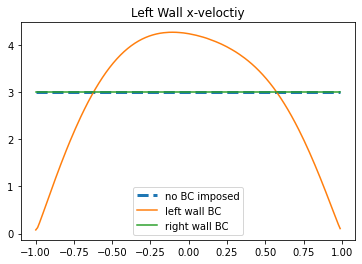

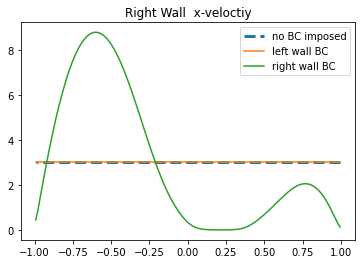

In [49]:
left_x_velocity = np.array(left_x_velocity)
plt.figure()
plt.plot(left_wall, left_x_velocity[:, 0],label='no BC imposed', lw=3, ls='--')
plt.plot(left_wall, left_x_velocity[:, 1],label='left wall BC')
plt.plot(left_wall, left_x_velocity[:, 2],label='right wall BC')
plt.title('Left Wall x-veloctiy')
plt.legend()
#plt.ylim([0, 250])
plt.show()

right_x_velocity = np.array(right_x_velocity)
plt.figure()
plt.plot(right_wall,right_x_velocity[:, 0],label='no BC imposed', lw=3, ls='--')
plt.plot(right_wall,right_x_velocity[:, 1],label='left wall BC')
plt.plot(right_wall,right_x_velocity[:, 2],label='right wall BC')
plt.title('Right Wall  x-veloctiy')
plt.legend()
plt.show()

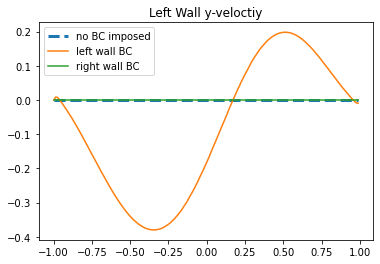

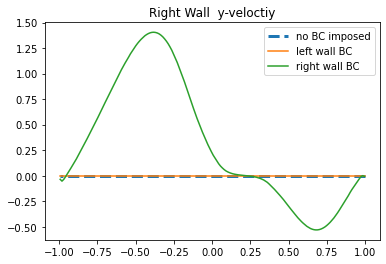

In [50]:
left_y_velocity = np.array(left_y_velocity)
plt.figure()
plt.plot(left_wall, left_y_velocity[:, 0],label='no BC imposed', lw=3, ls='--')
plt.plot(left_wall, left_y_velocity[:, 1],label='left wall BC')
plt.plot(left_wall, left_y_velocity[:, 2],label='right wall BC')
plt.title('Left Wall y-veloctiy')
plt.legend()
#plt.ylim([0, 250])
plt.show()

right_y_velocity = np.array(right_y_velocity)
plt.figure()
plt.plot(right_wall,right_y_velocity[:, 0],label='no BC imposed', lw=3, ls='--')
plt.plot(right_wall,right_y_velocity[:, 1],label='left wall BC')
plt.plot(right_wall,right_y_velocity[:, 2],label='right wall BC')
plt.title('Right Wall  y-veloctiy')
plt.legend()
plt.show()

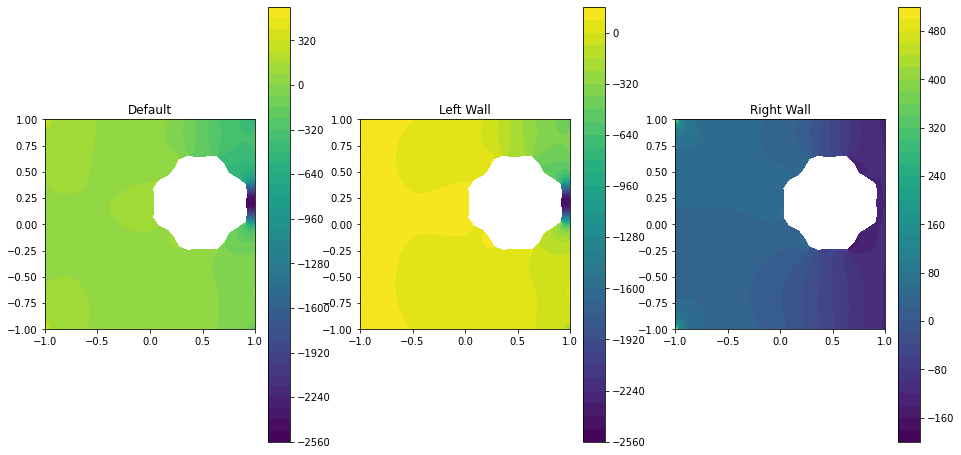

In [10]:
plt.figure(figsize=(16,8))

plt.subplot(1,3,1)
clr= fa.plot(p_default)
plt.colorbar(clr)
plt.title('Default')

plt.subplot(1,3,2)
clr= fa.plot(p_left)
plt.colorbar(clr)
plt.title('Left Wall')

plt.subplot(1,3,3)
clr= fa.plot(p_right)
plt.colorbar(clr)
plt.title('Right Wall')
plt.show()

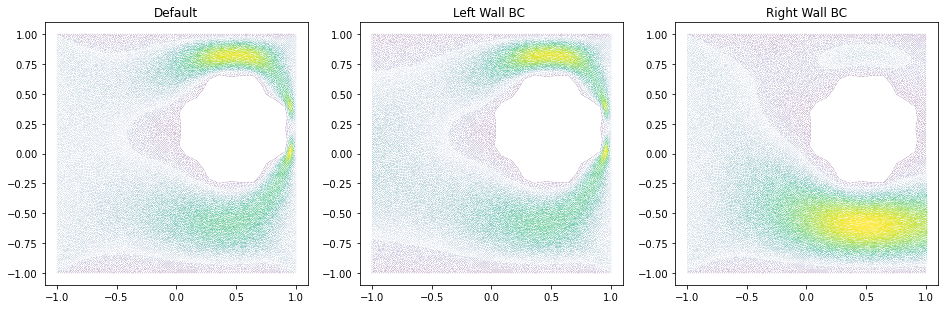

In [11]:
plt.figure(figsize=(16,8))

plt.subplot(1,3,1)
clr= fa.plot(u_default)
#plt.colorbar(clr)
plt.title('Default')

plt.subplot(1,3,2)
clr= fa.plot(u_left)
#plt.colorbar(clr)
plt.title('Left Wall BC ')

plt.subplot(1,3,3)
clr= fa.plot(u_right)
#plt.colorbar(clr)
plt.title('Right Wall BC')
plt.show()

# Loss Function 

In [12]:
taylor_default = SecondOrderTaylorLookup(u_p_default, all_points, d = 3)

In [13]:
taylor_left = SecondOrderTaylorLookup(u_p_left, all_points, d = 3)

In [14]:
taylor_right = SecondOrderTaylorLookup(u_p_right, all_points, d = 3)

In [55]:
jax_stress_loss_default = loss_stress_fn(taylor_default, points_in_domain, params)
jax_divu_loss_default = loss_divu_fn(taylor_default, points_in_domain, params)

jax_stress_loss_left = loss_stress_fn(taylor_left, points_in_domain, params)
jax_divu_loss_left = loss_divu_fn(taylor_left, points_in_domain, params)

jax_stress_loss_right = loss_stress_fn(taylor_right, points_in_domain, params)
jax_divu_loss_right = loss_divu_fn(taylor_right, points_in_domain, params)

In [58]:
print('stress loss')
print('BC     loss_total    loss_median')
print('no BC', np.sum(jax_stress_loss_default, axis=0), np.median(jax_stress_loss_default, axis=0))
print('left BC', np.sum(jax_stress_loss_left, axis=0), np.median(jax_stress_loss_left, axis=0))
print('right BC', np.sum(jax_stress_loss_right, axis=0), np.median(jax_stress_loss_right, axis=0))


print('div u loss')
print('BC     loss_total    loss_median')
print('no BC', np.sum(jax_divu_loss_default, axis=0), np.median(jax_divu_loss_default, axis=0))
print('left BC',np.sum(jax_divu_loss_left, axis=0), np.median(jax_stress_loss_left, axis=0))
print('right BC',np.sum(jax_divu_loss_right, axis=0), np.median(jax_stress_loss_right, axis=0))

stress loss
BC     loss_total    loss_median
no BC 6629801.0 0.060455304
left BC 6607226.5 0.034106247
right BC 170622.08 0.04570102
div u loss
BC     loss_total    loss_median
no BC 293.54013 9.999761e-07
left BC 292.84753 0.034106247
right BC 40.57411 0.04570102


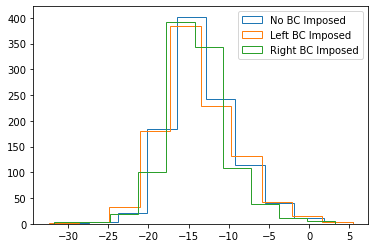

In [59]:
plt.figure()
plt.hist(np.log(jax_divu_loss_default), histtype='step', label='No BC Imposed')
plt.hist(np.log(jax_divu_loss_left), histtype='step', label='Left BC Imposed')
plt.hist(np.log(jax_divu_loss_right), histtype='step', label='Right BC Imposed')
plt.legend()
plt.show()

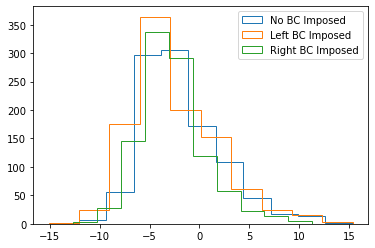

In [60]:
plt.figure()
plt.hist(np.log(jax_stress_loss_default), histtype='step', label='No BC Imposed')
plt.hist(np.log(jax_stress_loss_left), histtype='step', label='Left BC Imposed')
plt.hist(np.log(jax_stress_loss_right), histtype='step', label='Right BC Imposed')
plt.legend()
plt.show()

In [47]:
#p_default_vec  = p_default.vector().vec().getArray()
#p_low_vec  = p_low.vector().vec().getArray()
#p_median_vec  = p_median.vector().vec().getArray()
#p_high_vec  = p_high.vector().vec().getArray()

#u_default_vec  = u_default.vector().vec().getArray()
#u_low_vec  = u_low.vector().vec().getArray()
#u_median_vec  = u_median.vector().vec().getArray()
#u_high_vec  = u_high.vector().vec().getArray()

In [18]:
default_vals = taylor_default(points_in_domain)
left_vals = taylor_left(points_in_domain)
right_vals = taylor_right(points_in_domain)
left_diff = left_vals - default_vals
right_diff = right_vals - default_vals

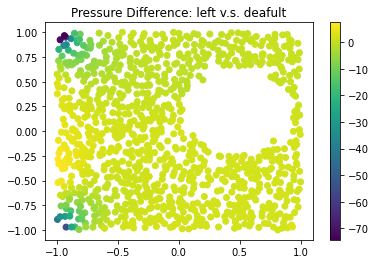

Pressure Val Fraction Difference
[2.51649612e-06 8.46375036e-03 2.44973823e-02 4.78445990e-02
 1.68866920e+01]


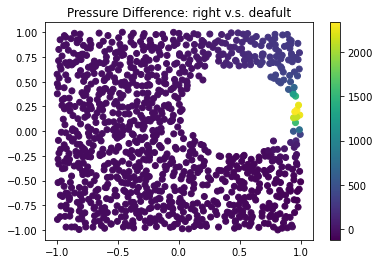

Pressure Val Fraction Difference
[4.98539349e-03 4.52549100e-01 6.12008601e-01 8.73073325e-01
 6.86380127e+02]


In [19]:
plt.figure()
#clr = plt.scatter(all_points[:,0], all_points[:,1], c=np.log(np.abs(diff[:, 2])))
clr = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c=left_diff[:, 2])
plt.title('Pressure Difference: left v.s. deafult')
plt.colorbar(clr)
plt.show()
print('Pressure Val Fraction Difference')
print(np.quantile(np.abs(left_diff[:, 2])/np.abs(default_vals[:,2]), q = [0, 0.25, 0.5, 0.75, 1.0]))

plt.figure()
#clr = plt.scatter(all_points[:,0], all_points[:,1], c=np.log(np.abs(diff[:, 2])))
clr = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c=right_diff[:, 2])
plt.title('Pressure Difference: right v.s. deafult')
plt.colorbar(clr)
plt.show()
print('Pressure Val Fraction Difference')
print(np.quantile(np.abs(right_diff[:, 2])/np.abs(default_vals[:,2]), q = [0, 0.25, 0.5, 0.75, 1.0]))

#plt.figure()
##clr = plt.scatter(all_points[:,0], all_points[:,1], c=np.log(np.abs(diff[:, 2])))
#clr = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c=diff[:, 0])
#plt.colorbar(clr)
#plt.show()



#plt.figure()
##clr = plt.scatter(all_points[:,0], all_points[:,1], c=np.log(np.abs(diff[:, 2])))
#clr = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c=diff[:, 1])
#plt.colorbar(clr)
#plt.show()

# Ignore Below

In [54]:
u, p = fa.split(u_p_median)

In [55]:
div_u_fenics = fa.div(u)

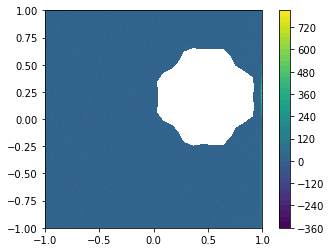

In [56]:
clrs = fa.plot(div_u_fenics)
plt.colorbar(clrs)

In [42]:
div_u_fenics

Div(ListTensor(Indexed(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 516), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 531), MultiIndex((FixedIndex(0),))), Indexed(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 516), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 531), MultiIndex((FixedIndex(1),)))))

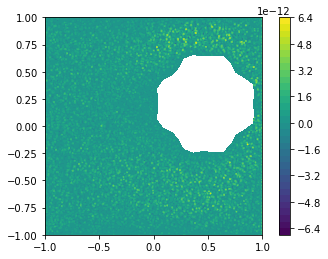

In [71]:
trace_jac_u_fenics = fa.tr(fa.grad(u))
clrs = fa.plot(trace_jac_u_fenics)
plt.colorbar(clrs)

In [23]:
fa.assemble(div_u_fenics*fa.dx)

1.896170269182214e-14

In [25]:
jac_u = fa.project(fa.grad(u), 
                   fa.TensorFunctionSpace(u_p_default.function_space().mesh(), 'P', 2, (2, 2)), solver_type="mumps")

In [74]:
jac_u([0., 0.]).reshape(2,2)

array([[-6.5331258 , -8.57841763],
       [ 7.04891479,  6.5242604 ]])

In [75]:
jac_u([-0.02, -0.02]).reshape(2,2)

array([[-5.7557918 , -9.10962402],
       [ 4.86156115,  5.7548466 ]])

5.284534175160923

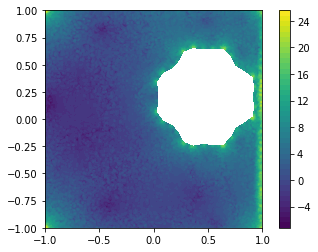

In [57]:
div_gradu_minus_p = fa.div(fa.grad(u) - p * fa.Identity(2))

lognorm = fa.ln(fa.inner(div_gradu_minus_p, div_gradu_minus_p))
clrs = fa.plot(lognorm)
plt.colorbar(clrs)

fa.assemble(lognorm*fa.dx)

In [47]:
V = u_p_high.function_space()
mesh = V.mesh()
degree = V.ufl_element().degree()
W = fa.VectorFunctionSpace(mesh, 'CG', degree, dim = 2)
div_gradu_minus_p_fn = fa.project(div_gradu_minus_p, W, solver_type='mumps')

In [48]:
div_gradu_minus_p_val = []
div_gradu_minus_p_fn.set_allow_extrapolation(True)
for pt in all_points:
    div_gradu_minus_p_val.append(div_gradu_minus_p_fn(pt))
div_gradu_minus_p_fn.set_allow_extrapolation(False)

(2218, 2)


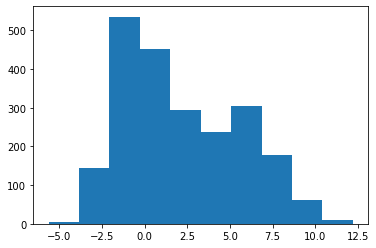

In [51]:
div_gradu_minus_p_val = np.array(div_gradu_minus_p_val)
print(div_gradu_minus_p_val.shape)
 
plt.figure()
plt.hist(np.log(np.linalg.norm(div_gradu_minus_p_val, axis = 1)))
plt.show()

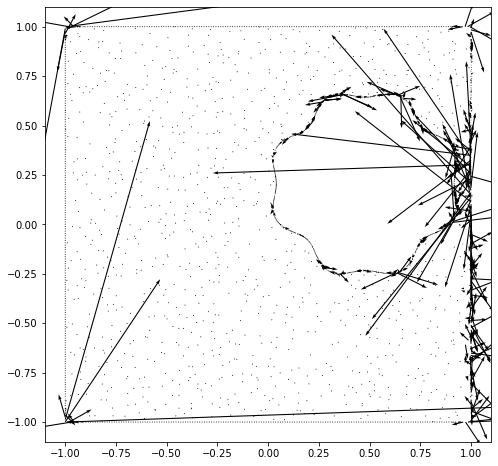

In [52]:
plt.figure(figsize = (8,8))
plt.quiver(all_points[:,0],all_points[:,1],div_gradu_minus_p_val[:,0],div_gradu_minus_p_val[:,1])

In [ ]:
u_p = solve_fenics(params, boundary_points=128, resolution=128)

In [ ]:
points = sample_points(jax.random.PRNGKey(args.seed + 1), 1024, params)
points_on_inlet, points_on_walls, points_on_holes, points_in_domain = points

all_points = np.concatenate(points)

In [ ]:
u, p = u_p.split()
fa.plot(u)

In [ ]:
x0 = points_in_domain[120]

In [ ]:
taylor = SecondOrderTaylorLookup(u_p, all_points, d = 3)

# Loss Function 

In [ ]:
jax_stress_loss = loss_stress_fn(taylor, points_in_domain, params)
jax_divu_loss = loss_divu_fn(taylor, points_in_domain, params)

print(np.mean(jax_stress_loss, axis=0))
print(np.mean(jax_divu_loss, axis=0))

plt.figure()
clrs = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c = np.array(jax_stress_loss))
plt.colorbar(clrs)
plt.show()

plt.figure()
clrs = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c = np.array(jax_divu_loss))
plt.colorbar(clrs)
plt.show()

In [ ]:
plt.figure()
plt.hist(np.log(jax_divu_loss))
plt.show()

In [ ]:
plt.figure()
plt.hist(np.log(jax_stress_loss))
plt.show()

In [ ]:
u, p = fa.split(u_p)

In [ ]:
div_u_fenics = fa.div(u)

In [ ]:
clrs = fa.plot(div_u_fenics)
plt.colorbar(clrs)

In [ ]:
trace_jac_u_fenics = fa.tr(fa.grad(u))
clrs = fa.plot(trace_jac_u_fenics)
plt.colorbar(clrs)

In [ ]:
fa.assemble(div_u_fenics*fa.dx)

In [ ]:
jac_u = fa.project(fa.grad(u), fa.TensorFunctionSpace(u_p.function_space().mesh(), 'P', 2, (2, 2)))

In [ ]:
jac_u([0., 0.]).reshape(2,2)

In [ ]:
jac_u([-0.02, -0.02]).reshape(2,2)

In [ ]:
div_gradu_minus_p = fa.div(fa.grad(u) - p * fa.Identity(2))

lognorm = fa.ln(fa.inner(div_gradu_minus_p, div_gradu_minus_p))

clrs = fa.plot(lognorm)
plt.colorbar(clrs)

fa.assemble(lognorm*fa.dx)